# Projet 7 : Réalisez des indexations automatiques d’images
# <u>A. Analyse et préparation des données</u> <br/>

# Le contexte

Pour aider une association de protection des animaux, nous mettons en place une solution de détéction automatique de la race d'un chien à partir d'une photo de celui-ci. Nous essayerons une approche classique dans un premier temps, puis une approche basée sur les réseaux de neurones.

Dans ce notebook nous allons récupérer les données "Stanford Dogs Dataset" contenant de nombreuses photos de chiens et que nous utiliserons pour entrainer et évaluer notre algorithme. Nous allons nous familiariser avec les données et les techniques de traitement d'images. Puis nous allons préparer la structures des fichiers afin de pouvoir tester nos différentes approches de modélisation.

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import imshow, show


import os
import shutil
import random

from scipy import io
import scipy.ndimage as spi
from glob import glob

import time

import cv2

from PIL import Image, ImageOps, ImageFilter
from matplotlib.pyplot import imshow

%matplotlib inline

### Les répértoires

In [2]:
DATA_DIR = 'data'
LIST_DIR = DATA_DIR + '/lists'
IMAGE_DIR = DATA_DIR + '/Images'
TRAIN_DIR = DATA_DIR + '/train'
TEST_DIR = DATA_DIR + '/test'
TRAIN_DIR_CNN = DATA_DIR + '/train_cnn'
TEST_DIR_CNN = DATA_DIR + '/test_cnn'
ANNOTATION_DIR = DATA_DIR + '/Annotation'

# 1. Analyse exploratoire

- Voyons tout d'abord la volumétrie de nos données :

In [3]:
image_files = glob(IMAGE_DIR + '/*/*.jpg')
folders = [ name for name in os.listdir(IMAGE_DIR) if os.path.isdir(os.path.join(IMAGE_DIR, name)) ]

In [4]:
print("Total races (dossier) : ", len(folders))
print("Total images  : ",len(image_files))

Total races (dossier) :  120
Total images  :  20581


==> Notre dataset est donc composé de plus de **20 000 photos** de **120 races** de chiens.

- Avons nous des images de même taille ?

In [5]:
img_size = np.asarray([plt.imread(f).shape for f in image_files])

Text(0,0.5,'hauteur')

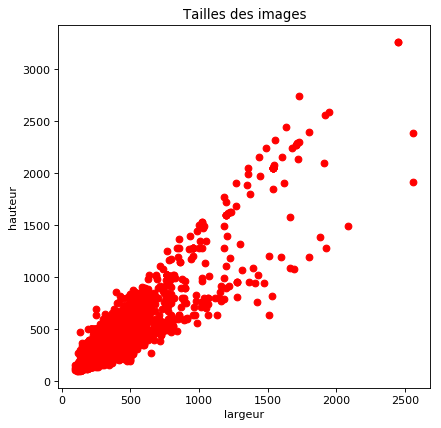

In [6]:
plt.figure(figsize=(6, 6), dpi=80)
plt.scatter(img_size[:,0], img_size[:,1], c = 'red')
plt.title("Tailles des images")
plt.xlabel("largeur")
plt.ylabel("hauteur")

==> La taille des images est assez variables avec une grande majorité d'images ayant une taille (hauteur / largeur) inférieure à 1000 pixels.

- Voyons maintenant le nombre d'images par race de chien.

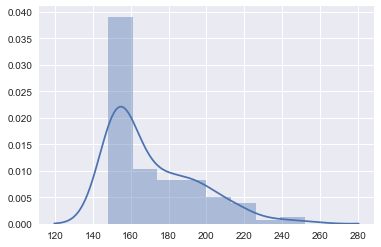

In [10]:
sns.set(color_codes=True)
images_per_feed = np.array([len(glob(IMAGE_DIR + "/" + f + '/*.jpg')) for f in folders])
sns.distplot(images_per_feed)

- Chaque dossier contient au minimum 150 images. 
- La grande majorité des dossiers ont 150 images.
- Le maximum d'images est de 280

# 2. Annotations

Le dataset contient un fichier d'annotations. Celui-ci comprend notamment pour chaque image la position du rectangle qui délimite le chien dans la photo. 
- Lecture du fichier des annotations

In [11]:
from xml.dom import minidom
rows_list = []
for root, subdirs, files in os.walk(ANNOTATION_DIR):
    for filename in files:
        if (filename.startswith('n')) :
            file_path = os.path.join(root, filename)
            with open(file_path, 'rb') as f:
                annon_xml = minidom.parse(f)
                dog_info={}
                a_folder = annon_xml.getElementsByTagName('folder')[0].firstChild.nodeValue
                a_filename = annon_xml.getElementsByTagName('filename')[0].firstChild.nodeValue
                if (a_folder == '%s') :
                    a_folder = filename.split('_')[0][1:]
                dog_info['folder'] = a_folder
                if (a_filename == '%s') :
                    a_filename = filename   
                dog_info['filename'] = a_filename
                dog_info['breed'] = annon_xml.getElementsByTagName('name')[0].firstChild.nodeValue
                dog_info['xmin'] = int(annon_xml.getElementsByTagName('xmin')[0].firstChild.nodeValue)
                dog_info['ymin'] = int(annon_xml.getElementsByTagName('ymin')[0].firstChild.nodeValue)
                dog_info['xmax'] = int(annon_xml.getElementsByTagName('xmax')[0].firstChild.nodeValue)
                dog_info['ymax'] = int(annon_xml.getElementsByTagName('ymax')[0].firstChild.nodeValue)
                rows_list.append(dog_info)
annotations_df=pd.DataFrame(rows_list)
annotations_df = annotations_df[['folder', 'filename', 'breed', 'xmin', 'ymin', 'xmax', 'ymax']]

Pour chaque fichier, nous récupérer les positions du rectange de délimitation.

In [12]:
annotations_df.head()

,folder,filename,breed,xmin,ymin,xmax,ymax
0,02097658,n02097658_98,silky_terrier,93,117,269,289
1,02097658,n02097658_2535,silky_terrier,216,69,498,289
2,02097658,n02097658_271,silky_terrier,0,0,366,331
3,02097658,n02097658_427,silky_terrier,174,1,1018,762
4,02097658,n02097658_4890,silky_terrier,124,27,357,281


# 3.  Manipulation des images

Dans cette partie nous allons tester différentes techniques de manipulation/traitement d'images afin de mieux se les approprier pour la phase apprentissage.

In [13]:
'''
Affichage côte à côté de 2 images
'''
def show_images(img1, cmap1, img2, cmap2) :
    f = plt.figure(figsize=(10,10))
    i1 = f.add_subplot(1,2, 1)
    i1.axis('off')
    imshow(img1, cmap = cmap1)
    i2 = f.add_subplot(1,2, 2)
    i2.axis('off')
    imshow(img2, cmap=cmap2)
    plt.show(block=True)

- Affichons une image prise dans le dossier des images.

Largeur : 427 px, hauteur : 392 px channels: 3


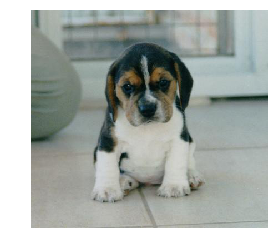

In [14]:
img_orig = cv2.imread(IMAGE_DIR + '/n02088364-beagle/n02088364_1507.jpg')
# Récupérer et afficher la taille de l'image (en pixels)
h, w, channel = img_orig.shape
print("Largeur : {} px, hauteur : {} px channels: {}".format(w, h, channel))
plt.axis('off')
imshow(cv2.cvtColor(img_orig, cv2.CV_32S))

### Gray Scale

- On passe de la couleur au noir et blanc

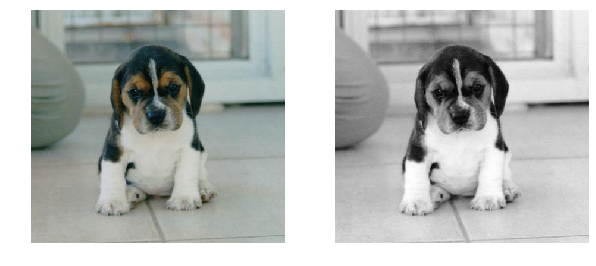

In [12]:
gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, gray, 'gray')

## Histogram

- Application des techniques d'égalisation de l'histogramme.

### Equalize Histogram

- Affichons l'histogramme de l'image de départ.

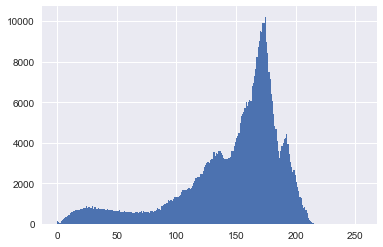

In [13]:
n, bins, patches = plt.hist(np.array(img_orig).flatten(), bins=range(256))
plt.show()

- On utilise la méthode d'égalisation d'openCV

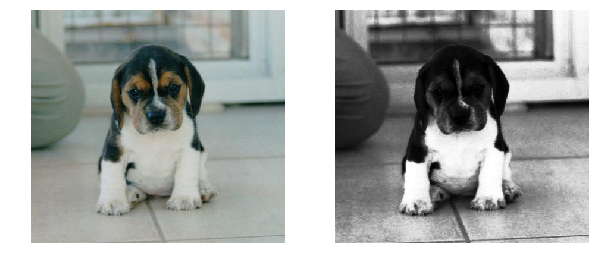

In [14]:
gray_image = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
equ = cv2.equalizeHist(gray_image)
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, equ, 'gray')

- On constate effectivement la modification dans l'histrogramme.

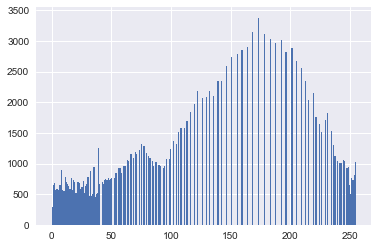

In [15]:
n, bins, patches = plt.hist(np.array(equ).flatten(), bins=range(256))
plt.show()

### CLAHE (Contrast Limited Adaptive Histogram Equalization)

- Testons une autre technique d'égalisation appelé CLAHE

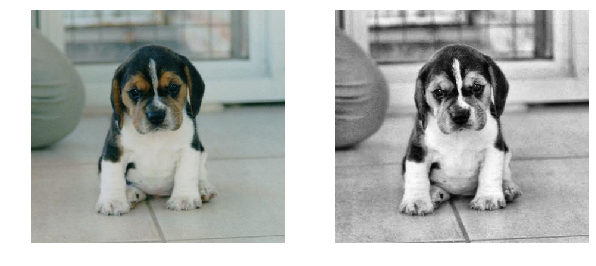

In [16]:
gray_image = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(gray_image)

show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cl1, 'gray')

=> Image transformé est de meilleure qualité que précédement.

## Cropping

- Centrons sur une image autour de la silhouette du chien en se basant sur le fichier annotation.

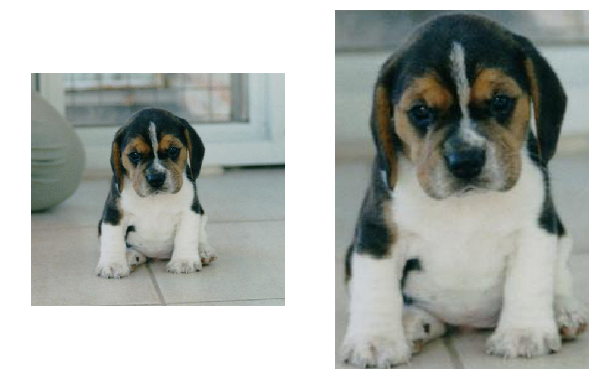

In [17]:
box = annotations_df[annotations_df['filename'] == 'n02088364_1507']
cropped_img = img_orig[int(box.ymin):int(box.ymax), int(box.xmin):int(box.xmax)]
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cv2.cvtColor(cropped_img, cv2.CV_32S), None)

## Image Smoothing

- Voyons maintenant les techniques de lissage

### Averaging

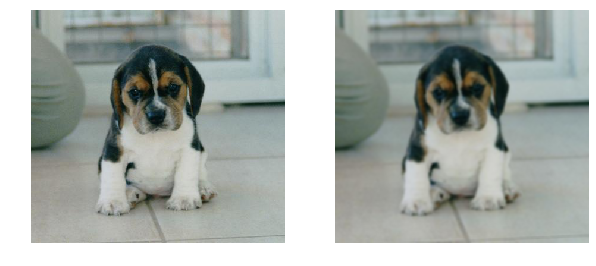

In [18]:
blur = cv2.blur(img_orig,(5,5))
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cv2.cvtColor(blur, cv2.CV_32S), None)

### Gaussian Blur

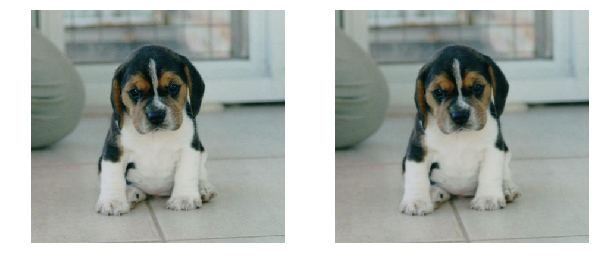

In [19]:
blur = cv2.GaussianBlur(img_orig,(0,0), 0.5)
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cv2.cvtColor(blur, cv2.CV_32S), None)


=> Le filtre Gaussian donne une meilleure image

## Removing background

- Essayons maintenant la technique de suppression de l'arrière plan pour ne garder que l'image du chien. Nous utiliserons pour celà le grabcut de la librairie OpenCV.

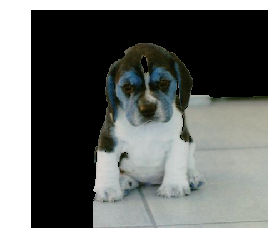

In [20]:
mask = np.zeros(img_orig.shape[:2],np.uint8)
height, width, channels = img_orig.shape

# temporary arrays used by grabCut
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)
nb_iter = 2

rect = (5, 5, width - 5, height - 5)

cv2.grabCut(img_orig,mask,rect,bgdModel,fgdModel,nb_iter,cv2.GC_INIT_WITH_RECT)
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
img_grabcut = img_orig * mask2[:, :, np.newaxis]

plt.axis('off')
plt.imshow(img_grabcut)

=> Le détourage n'est pas parfait mais il l'a fait en partie. On améliore le traitement, en indiquant avec précision le rectangle pour le détourage. Cependant c'est une technique qui est consommatrice de ressource (temps élevé juste pour une image).

## Horizontal flip

- Essayons maintenant les techniques d'augmentation des images (effet mirroir, rotation, ...)

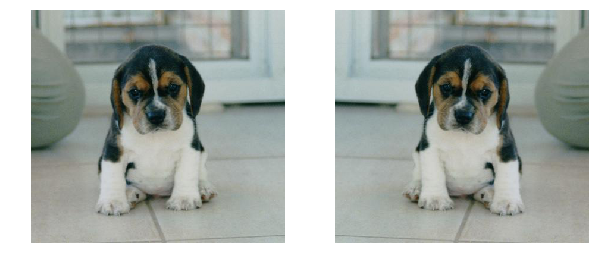

In [21]:
flip_img = cv2.flip(img_orig, 1 )
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cv2.cvtColor(flip_img, cv2.CV_32S), None)

## Ajout de bruits (Gaussian Noise)

- Ajoutons du bruit gaussien au niveau de l'image (autre technique de Data Augmentation)

In [22]:
def add_gaussian_noise(image_in, noise_sigma):
    temp_image = np.float64(np.copy(image_in))
    h = temp_image.shape[0]
    w = temp_image.shape[1]
    noise = np.random.randn(h, w) * noise_sigma
    noisy_image = np.zeros(temp_image.shape, np.float64)
    if len(temp_image.shape) == 2:
        noisy_image = temp_image + noise
    else:
        noisy_image[:,:,0] = temp_image[:,:,0] + noise
        noisy_image[:,:,1] = temp_image[:,:,1] + noise
        noisy_image[:,:,2] = temp_image[:,:,2] + noise
    return noisy_image


def convert_to_uint8(image_in):
    temp_image = np.float64(np.copy(image_in))
    cv2.normalize(temp_image, temp_image, 0, 255, cv2.NORM_MINMAX, dtype=-1)

    return temp_image.astype(np.uint8)

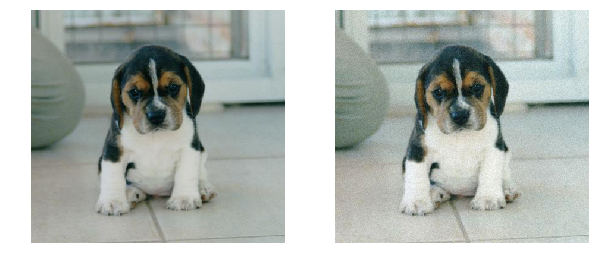

In [23]:
noisy_sigma = 5
noisy = convert_to_uint8(add_gaussian_noise(img_orig, noisy_sigma))
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cv2.cvtColor(noisy, cv2.CV_32S), None)

## Rotation aléatoire de l'image

In [24]:
def rotate_img(image, angle):
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))

On choisit un coefficient de rotation aléatoire et on l'applique à l'image.

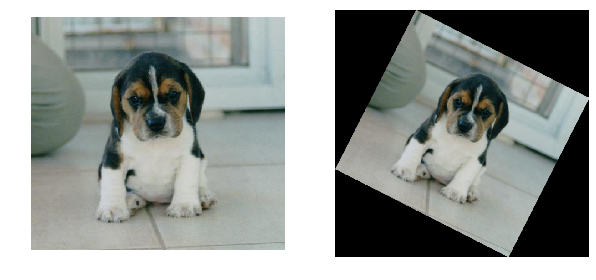

In [25]:
random_degree = random.uniform(-30, 30)
rot_img = rotate_img(img_orig, random_degree)
show_images(cv2.cvtColor(img_orig, cv2.CV_32S),None, cv2.cvtColor(rot_img, cv2.CV_32S), None)

# 4. SIFT features

La détection de points d’intérêt dans les images facilite la reconnaissance d'image. Le descripteur SIFT est le plus couramment utilisé pour l’extraction de points clés. Il est peu sensible au changement d’intensité, de mise à l’échelle et de rotation, ce qui fait de lui un descripteur très robuste.

- Testons l'extraction SIFT sur une image.

In [26]:
def show_rgb_img(img):
    """Convenience function to display a typical color image"""
    plt.axis('off')
    return plt.imshow(cv2.cvtColor(img, cv2.CV_32S))

def to_gray(color_img):
    gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    return gray

def feature_extract(gray_img):
    sift = cv2.xfeatures2d.SIFT_create()
    # kp is the keypoints
    # desc is the SIFT descriptors
    kp, desc = sift.detectAndCompute(gray_img, None)
    return kp, desc

def show_sift_features(gray_img, color_img, kp):
    plt.axis('off')
    return plt.imshow(cv2.drawKeypoints(gray_img, kp, color_img.copy()))

In [27]:
image_path = IMAGE_DIR + '/n02085936-Maltese_dog/n02085936_544.jpg'

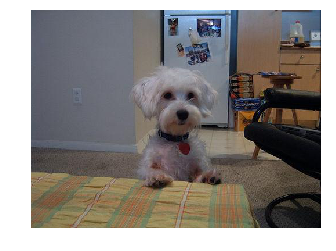

In [28]:
image = cv2.imread(image_path)
show_rgb_img(image)
image_gray = to_gray(image)

- Recherche des points clés et des descripteurs.

In [29]:
kp, desc = feature_extract(image_gray)

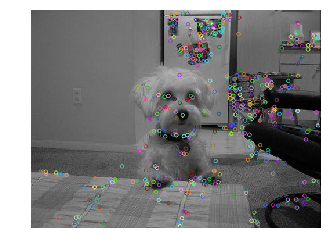

In [30]:
show_sift_features(image_gray, image, kp)

=> Les cercles de couleurs représentes les points clés détectés dans l'image. Nous voyons qu'en plus du chien, d'autres élèments de l'image sont détectés.

- Voyons maintenant la détéction pour l'image centrée sur le chien.

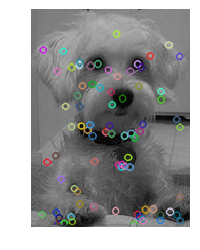

In [31]:
box = annotations_df[annotations_df['filename'] == 'n02085936_544']
cropped_img = image[int(box.ymin):int(box.ymax), int(box.xmin):int(box.xmax)]
img_gray = to_gray(cropped_img)
kp, desc = feature_extract(img_gray)
show_sift_features(img_gray, cropped_img, kp)

=> Le résultat est meilleur.

# 5. Préparation du jeu de données

Préparons maintenant les fichiers afin de tester nos différentes approches de prédictions.
En raison de la taille des images et de notre limitation de ressource matérielle, nous allons nous limiter notre projet à 4 races de chiens.

## Choix des races de chiens

Nous sélectionnons 4 races de chiens pour ce projet. 

In [32]:
breeds_to_use = ['Siberian_husky', 'Chihuahua', 'Maltese_dog', 'Scotch_terrier']#, 'Irish_setter']

On récupère le nom des dossiers qui se trouvent dans _Images_ et qui contiennent notre selection de races.

In [33]:
image_paths = glob(IMAGE_DIR + '/*')
project_image_folders = [s[12:] for s in image_paths if s.split('-')[1] in breeds_to_use]

In [34]:
project_image_folders

['n02110185-Siberian_husky',
 'n02085936-Maltese_dog',
 'n02085620-Chihuahua',
 'n02097298-Scotch_terrier']

## Sauvegarde des images dans les dossiers entrainement et test

In [38]:
def save_original_images(img_list , dest_folder):
    for file in img_list:
        breed_name = file.split("/")[0].split('-')[1]
        filename = file.split("/")[-1]
        shutil.copyfile(os.path.join(IMAGE_DIR, file), os.path.join(dest_folder, breed_name, filename))

In [39]:
def save_cropped_images(img_list, dest_folder):
    crop_prefix='_crop'
    for file in img_list:
        breed_name = file.split("/")[0].split('-')[1]
        filename = file.split("/")[-1]
        img_orig =  Image.open(os.path.join(IMAGE_DIR, file))
        img_crop = img_orig.crop(retrieveBoxingArea(filename[:-4]))
        img_crop.save(os.path.join(dest_folder, breed_name, get_extended_filename(filename, crop_prefix)))        

### Avec Data Augmentation

Ayant peu d'images par chiens (une centaine dans le dossier d'entrainement), nous allons utiliser la technique de Data Augmentation pour rajouter 
d'autres images de nos chiens (pivot, rotation, centrage sur le rectangle de délimitation du chien, ...)

In [35]:
'''
Retourne le rectangle de délimitation du chien dans un fichier image.
'''
def retrieveBoxingArea(filename) :
    box = annotations_df[annotations_df['filename'] == filename]
    area = (int(box.xmin), int(box.ymin), int(box.xmax), int(box.ymax))
    return area

In [36]:
def get_extended_filename(filename, prefix) :
    ext = filename[-4:]
    return (filename[:-4] + prefix + ext)

In [37]:
'''
Sauvegarde des images augmentés de la liste dans le répértoire de destination.
- centré sur image du chien
- pivot gauche droite
- centré image chien et pivot gauche droite
- rotation aléatoire de l'image
'''
def save_augmented_images(img_list, dest_folder):
    crop_prefix='_crop'
    flip_prefix='_flip'
    crop_flip_prefix='_cropflip'
    rotate_prefix = 'rotate'
    for file in img_list:
        breed_name = file.split("/")[0].split('-')[1]
        filename = file.split("/")[-1]     
        # Load image
        img_orig =  Image.open(os.path.join(IMAGE_DIR, file))
        # horizontal flip
        img_flip = img_orig.transpose(Image.FLIP_LEFT_RIGHT)
        img_flip.save(os.path.join(dest_folder, breed_name, get_extended_filename(filename, flip_prefix)))      
        # cropping
        img_crop = img_orig.crop(retrieveBoxingArea(filename[:-4]))
        img_crop.save(os.path.join(dest_folder, breed_name, get_extended_filename(filename, crop_prefix)))
        # flip cropped
        img_fcrop = img_crop.transpose(Image.FLIP_LEFT_RIGHT)
        img_fcrop.save(os.path.join(dest_folder, breed_name, get_extended_filename(filename, crop_flip_prefix)))
        #rotation
        random_degree = random.uniform(-40, 40)
        img_rot = img_orig.rotate(random_degree)
        img_rot.save(os.path.join(dest_folder, breed_name, get_extended_filename(filename, rotate_prefix)))
       

## Préparation des images pour approche classique

- On se base sur les fichiers train_list.mat et test_list.mat pour constituer nos fichiers d'entrainement et de test pour nos 4 races de chiens.

In [40]:
train_list = io.loadmat(LIST_DIR +'/train_list.mat')['file_list']
train_list = np.array([t[0] for t in train_list[:,0] if t[0].split('/')[0] in project_image_folders ])

test_list = io.loadmat(LIST_DIR +'/test_list.mat')['file_list']
test_list = np.array([t[0] for t in test_list[:,0] if t[0].split('/')[0] in project_image_folders ])

- On copie les fichiers originaux et augmentés dans le dossier entrainement.

In [43]:
if (os.path.exists(TRAIN_DIR)) :
    print("Removing", TRAIN_DIR)
    shutil.rmtree(TRAIN_DIR)
if (os.path.exists(TEST_DIR)) :
    print("Removing", TEST_DIR)
    shutil.rmtree(TEST_DIR) 

for folder in project_image_folders:
    folder_name = folder.split('-')[1]
    os.makedirs(TRAIN_DIR + '/' + folder_name)
    os.makedirs(TEST_DIR + '/' + folder_name)
    
save_original_images(train_list, TRAIN_DIR)
save_augmented_images(train_list, TRAIN_DIR)
save_cropped_images(test_list, TEST_DIR)

### Images information

On y ajoute aussi un fichier contenant les différentes informations de nos images (le chemin du fichier, la race)

In [44]:
def save_img_info(image_folder) :
    rows_list = []
    for each in glob(image_folder + "/*"):
        if not(os.path.isdir(each)):
            continue
        breed_name = each.split("/")[-1]
        for imagefile in glob(each+"/*"):
            file_info={}
            file_info['filepath'] = imagefile.replace(image_folder+'/', '')
            file_info['breed'] = breed_name
            rows_list.append(file_info)
    labels=pd.DataFrame(rows_list)
    labels = labels[['filepath', 'breed']]
    labels.to_csv(image_folder + '/images_infos.csv', index=False)

On sauve les fichiers au format CSV dans les 2 dossiers.

In [45]:
save_img_info(TRAIN_DIR)
save_img_info(TEST_DIR)

## Préparation des images  pour le CNN

Pour  les traitement des réseaux CNN, nous avons utiliser les techniques d'augmentation de données manuelles. Nous sauvons donc juste l'image originale et l'image centrée sur le chien pour l'entrainement.

In [47]:
if (os.path.exists(TRAIN_DIR_CNN)) :
    print("Removing", TRAIN_DIR_CNN)
    shutil.rmtree(TRAIN_DIR_CNN)
if (os.path.exists(TEST_DIR_CNN)) :
    print("Removing", TEST_DIR_CNN)
    shutil.rmtree(TEST_DIR_CNN)

for folder in project_image_folders:
    folder_name = folder.split('-')[1]
    os.makedirs(TRAIN_DIR_CNN + '/' + folder_name)
    os.makedirs(TEST_DIR_CNN + '/' + folder_name)

save_original_images(train_list, TRAIN_DIR_CNN)
save_cropped_images(train_list, TRAIN_DIR_CNN)
save_cropped_images(test_list, TEST_DIR_CNN)
save_original_images(train_list, TRAIN_DIR_CNN)

Removing data/train_cnn
Removing data/test_cnn
